In [10]:
try:
    from langchain_core.document_loaders.base import BaseLoader
    from langchain_core.documents.base import Document
except ImportError:
    raise ImportError(
        "langchain package not found, please install it with `pip install langchain-core`"
    )

class NornikelPdfLoader(BaseLoader):
    def __init__(
        self,
        file_path: str,
    ) -> None:
        """Initialize with a file path."""
        try:
            from pypdf import PdfReader
        except ImportError:
            raise ImportError(
                "pypdf package not found, please install it with `pip install pypdf`"
            )
        self.parser = PdfReader(file_path)
        self.file_path = file_path

    def load(self) -> list[Document]:

        def load_images_from_page(page) -> list[Document]:
            import base64
            metadata = {
                "source": self.file_path,
                "page": page.page_number,
                "type": "image",
            } | self.parser.metadata

            ret_docs: list[Document] = []
            for image in page.images:
                # Конвертируем бинарные данные в base64
                base64_data = base64.b64encode(image.data).decode('utf-8')
                # Добавляем в формате data:image/jpeg;base64,{data}
                base64_str = f"data:image/jpeg;base64,{base64_data}"
                # Добавляем в список документов
                ret_docs.append(Document("<IMG>", metadata=metadata 
                                         | {"image_base64": base64_str}
                                         ))
            return ret_docs

        def extract_texts_from_page(page) -> list[Document]:
            metadata = {
                "source": self.file_path,
                "page": page.page_number,
                "type": "text",
            } | self.parser.metadata

            return [Document(page.extract_text(), metadata=metadata)]

        ret_documents: list[Document] = []
        for page in self.parser.pages:
            ret_documents.extend(load_images_from_page(page))
            ret_documents.extend(extract_texts_from_page(page))
        return ret_documents


In [11]:
nornikel_loader = NornikelPdfLoader("../data/Доклад, уголь часть 1.pdf")
docs = nornikel_loader.load()

In [12]:
len(docs)

97

Document(metadata={'source': '../data/Доклад, уголь часть 1.pdf', 'page': 0, '/Producer': 'pdf-lib (https://github.com/Hopding/pdf-lib)', '/ModDate': 'D:20241016224200Z', '/Creator': '1', '/CreationDate': 'D:20241016224200Z', '/Title': 'Доклад №1', '/Author': '1', '/Keywords': 'DAFseJ6uM3c BAFlQ5Z3D20', '/Subject': '', 'image_base64': ''}, page_content='<IMG>')
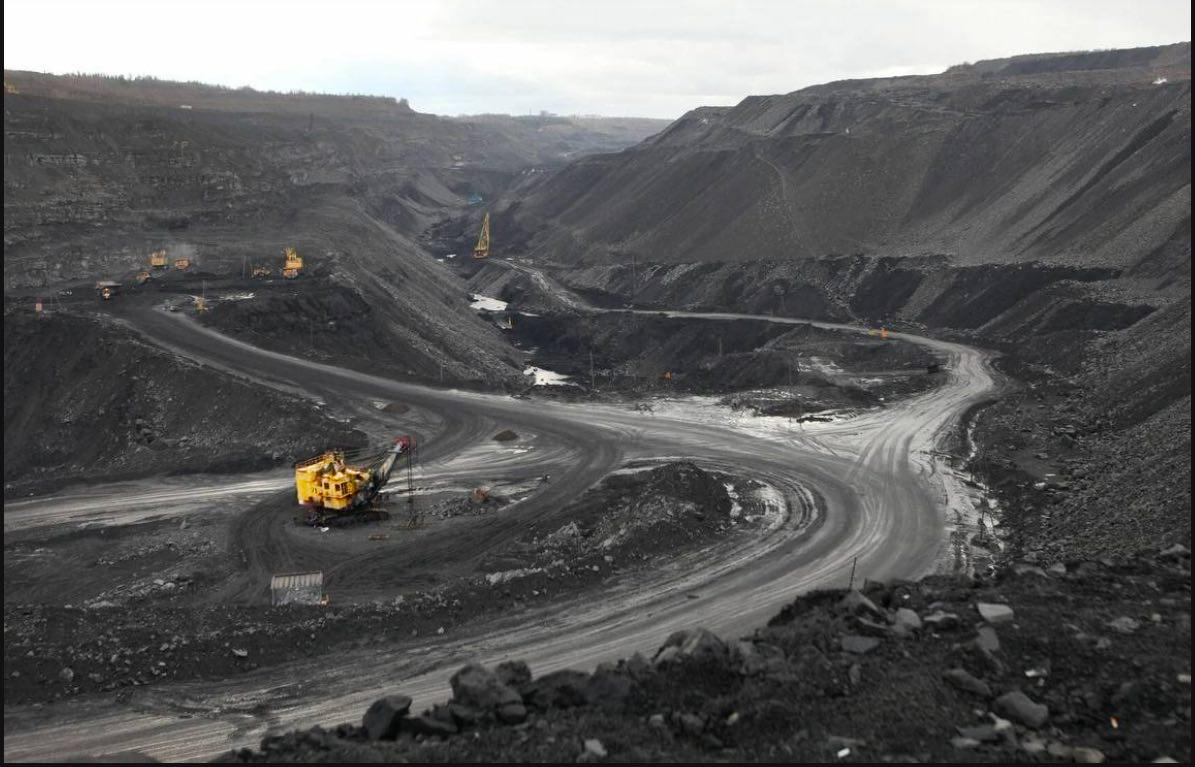

In [13]:
docs[0]